<center><h1>Supplemental Material</h1></center>

<br>
<center><h2>Simple and exact nonlinear pendulum motion for all possible initial conditions</h2></center>

Teepanis Chachiyo <teepanisc@nu.ac.th>
Department of Physics, Faculty of Science, Naresuan University, Phitsanulok 65000, Thailand.


### Available at a GitHub repository: [https://github.com/teepanis/nonlinear-pendulum](https://github.com/teepanis/nonlinear-pendulum)




## CKS

These python codes compute angular displacement $\theta(t)$ of the nonlinear pendulum using CKS as described in the paper. The main subroutines are:

1. **theta_CKS**(theta0, omega0, t, ...)
2. **phase_CKS**(theta0, omega0, ...)
3. **K_thiswork**(k)


In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

def K_exact(k):
    # scipy defines K differently, so that we need to pass k**2 insead of k
    return sp.special.ellipk(k**2)

def K_thiswork(k):
    n = (np.log(4) - np.log(np.pi))/(np.pi/2 - np.log(4))
    b = np.exp(n*np.pi/2) - 4**n
    return 1/n*np.log( (4/np.sqrt(1-k**2))**n + b)

#mode='exact'
mode='accurate'

def K(k):
    if mode=='exact': return K_exact(k)
    if mode=='accurate': return K_thiswork(k)
    
# compute magnitude of omegac
def get_omegac(g, L):
    return 2*np.sqrt(g/L)

# compute magnitude of omegaM
def get_omegaM(theta0, omega0, g, L):
    return np.sqrt(omega0**2 - 2*g/L*np.cos(theta0) + 2*g/L)

# compute omega0 consistent with stoppig motion
def get_omega0c(theta0, g, L):
    omegac = get_omegac(g, L)
    return np.sqrt(omegac**2 + 2*g/L*np.cos(theta0) - 2*g/L)

# compute phase shift for CKS
def phase_CKS(theta0, omega0, g, L, cutoff=1e-8, maxN=20):
    
    # special cases
    if theta0 == 0.0: return 0.0
    if omega0 == 0.0:
        if theta0 > 0: return +np.pi/2
        else: return -np.pi/2

    omegac = get_omegac(g, L)
    omegaM = get_omegaM(theta0, omega0, g, L)
    
    # swinging motion
    if omegaM < omegac:
                
        # compute coefficient an
        k = np.sqrt(L/g)*omegaM/2
        kappa = K(np.sqrt(1-k**2))/K(k)

        a = np.zeros(maxN)
        for j in range(1,maxN,2):
            a[j] = 4/j/np.cosh(kappa*j*np.pi/2)

        def f(delta):
            s = 0
            for j in range(1,maxN,2): s = s + a[j]*np.sin(j*delta)
            return theta0 - s

        def fp(delta):
            s = 0
            for j in range(1,maxN,2): s = s + j*a[j]*np.cos(j*delta)
            return -s

        # initial guess
        delta = np.arcsin(theta0/a[1])

        # update
        while True:
            step = - f(delta)/fp(delta)
            delta = delta + step
            if np.abs(step) < cutoff: break
                
    # stopping motion, omegaM == omegac
    elif np.abs(omegaM-omegac) < 1e-12:
        x = np.sin(theta0/2)
        delta = 1/2*np.log((1+x)/(1-x))
        
    # spining motion
    else:
        
        # compute coefficients
        b = np.zeros(maxN)
        k = np.sqrt(L/g)*omegaM/2
        kappa = K(np.sqrt(1-1/k**2))/K(1/k)
        for n in range(1,maxN):
            b[n] = 2/n/np.cosh(n*np.pi*kappa)

        def f(delta):
            s = 0
            for j in range(1,maxN,1): s = s + b[j]*np.sin(j*delta)
            return theta0 - delta - s

        def fp(delta):
            s = 0
            for j in range(1,maxN,1): s = s + j*b[j]*np.cos(j*delta)
            return -1-s
        
        # initial guess
        delta = theta0/(1+b[1])

        # update
        while True:
            step = - f(delta)/fp(delta)
            delta = delta + step
            if np.abs(step) < cutoff: break

    return delta

##
## the Chiang Khruea solutions (CKS)
##
def theta_CKS(theta0, omega0, t, g, L, maxN=20):
    
    theta = np.zeros(len(t))
    
    omegac = get_omegac(g, L)
    omegaM = get_omegaM(theta0, omega0, g, L)

    # For omega0 < 0, use mirror symmetry
    if omega0 < 0:
        theta0 = -theta0
        omega0 = -omega0
        mirror = True
    else:
        mirror = False
        
    # compute phase constant
    delta = phase_CKS(theta0, omega0, g, L, 1e-8, maxN)
    
    # swinging motion
    if omegaM < omegac:

        # compute period
        k = np.sqrt(L/g)*omegaM/2
        T = 4*np.sqrt(L/g)*K(k)

        # compute coefficients
        a = np.zeros(maxN)
        kappa = K(np.sqrt(1-k**2))/K(k)
        for n in range(1,maxN,2):
            a[n] = 4/n/np.cosh(kappa*n*np.pi/2)
        
        # sum contributions at time t
        for i in range(len(t)):
            s = 0
            for n in range(0,maxN): s = s + a[n]*np.sin(2*n*np.pi/T*t[i] + n*delta)
            theta[i] = s
    
    # stopping motion, omegaM == omegac
    elif np.abs(omegaM-omegac) < 1e-12:
        for i in range(len(t)):
            theta[i] = 2*np.arcsin( np.tanh(np.sqrt(g/L)*t[i] + delta) )
    
    # spinning motion
    else:
        # compute period
        k = np.sqrt(L/g)*omegaM/2
        T = 2*np.sqrt(L/g)/k*K(1/k)
        
        # compute coefficients
        b = np.zeros(maxN)
        kappa = K(np.sqrt(1-1/k**2))/K(1/k)
        for n in range(1,maxN):
            b[n] = 2/n/np.cosh(n*np.pi*kappa)
        
        # sum contributions at time t + 
        for i in range(len(t)):
            s = 0
            for n in range(0,maxN): s = s + b[n]*np.sin(2*n*np.pi/T*t[i] + n*delta)
            theta[i] = 2*np.pi/T*t[i] + delta + s

    if mirror == True: return -theta
    else: return theta


## List of Figures

Below are a list of figures that have been used in the paper. The data was generated by the python code below.

### Figure 1: Results of Angular Displacement using CKS

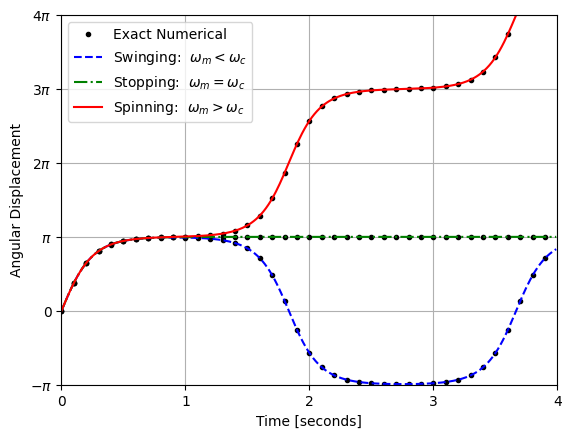

In [2]:
g = 9.8
L = g/4/np.pi**2

def theta_exact(omegaM, t):

    E = (1/2*omegaM**2)*L/g
    k = np.sqrt(L/g)*omegaM/2
    theta = np.zeros(len(t))
    
    for i in range(len(t)):
        
        if omegaM < omegac:
            [sn, cn, dn, ph] = sp.special.ellipj(np.sqrt(g/L)*t[i], k**2)
            theta[i] = 2*np.arcsin(k*sn)
        else:
            [sn, cn, dn, ph] = sp.special.ellipj(np.sqrt(g/L)*t[i]*np.sqrt(E/2), 
                                                 np.sqrt(2/E)**2)
            theta[i] = 2*ph
        
    return theta

omegac = get_omegac(g, L)

Tmax = 4
t = np.arange(0, Tmax, 0.01)

plt.plot(t, theta_exact(omegac-0.001,t),'k.',markevery=10,label='Exact Numerical')
plt.plot(t, theta_exact(omegac,t),'k.',markevery=10)
plt.plot(t, theta_exact(omegac+0.001,t),'k.',markevery=10)

plt.plot(t, theta_CKS(0,omegac-0.001,t,g,L),'b--',label='Swinging:  $\\omega_m < \\omega_c$')
plt.plot(t, theta_CKS(0,omegac,t,g,L),'g-.',label='Stopping:  $\\omega_m = \\omega_c$')
plt.plot(t, theta_CKS(0,omegac+0.001,t,g,L),'r-', label='Spinning:  $\\omega_m > \\omega_c$')
plt.ylim(-np.pi,4*np.pi)
plt.xlim(0,Tmax)
plt.yticks([-np.pi,0,np.pi,2*np.pi,3*np.pi,4*np.pi],
           ['$-\pi$','0','$\pi$','$2\pi$','$3\pi$','$4\pi$'])
plt.xticks([0,1,2,3,4])
plt.grid()
plt.legend()
plt.xlabel('Time [seconds]')
plt.ylabel('Angular Displacement')
#plt.savefig('fig1.pdf')
plt.show()

### Figure 2: Solutions of Phase Shift

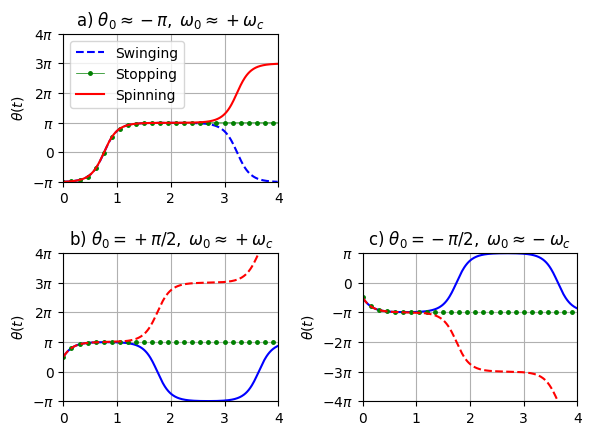

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Tmax = 4
t = np.arange(0,Tmax,0.01)

# a) theta0 near -pi, omega0 > 0
theta0 = -178/180*np.pi
omega0c = get_omega0c(theta0, g, L)
theta_swinging_a = theta_CKS(theta0, omega0c-0.001, t, g, L)
theta_stopping_a = theta_CKS(theta0, omega0c, t, g, L)
theta_spinning_a = theta_CKS(theta0, omega0c+0.001, t, g, L)

# b) theta0 = pi/2, omega0 > 0
theta0 = np.pi/2
omega0c = get_omega0c(theta0, g, L)
theta_swinging_b = theta_CKS(theta0, omega0c-0.001, t, g, L)
theta_stopping_b = theta_CKS(theta0, omega0c, t, g, L)
theta_spinning_b = theta_CKS(theta0, omega0c+0.001, t, g, L)

# c) theta0 = -pi/2, omega0 < 0
theta0 = -np.pi/2
omega0c = get_omega0c(theta0, g, L)
theta_swinging_c = theta_CKS(theta0, -(omega0c-0.001), t, g, L)
theta_stopping_c = theta_CKS(theta0, -omega0c, t, g, L)
theta_spinning_c = theta_CKS(theta0, -(omega0c+0.001), t, g, L)

fig, ax = plt.subplots(2,2)
fig.tight_layout(pad=3)

ax[0,0].set_title('a) $\\theta_0 \\approx -\pi,\\; \\omega_0 \\approx +\\omega_c$')
ax[0,0].plot(t, theta_swinging_a,'b--',label='Swinging')
ax[0,0].plot(t, theta_stopping_a,'g.-', linewidth=0.5, 
             markersize=5, markevery=15, label='Stopping')
ax[0,0].plot(t, theta_spinning_a,'r-', label='Spinning')

ax[1,0].set_title('b) $\\theta_0 =+\pi/2,\\; \\omega_0 \\approx +\\omega_c$')
ax[1,0].plot(t, theta_swinging_b,'b-')
ax[1,0].plot(t, theta_stopping_b,'g.', markersize=5, markevery=15)
ax[1,0].plot(t, theta_spinning_b,'r--')

ax[1,1].set_title('c) $\\theta_0 =-\pi/2,\\; \\omega_0 \\approx -\\omega_c$')
ax[1,1].plot(t, theta_swinging_c,'b-')
ax[1,1].plot(t, theta_stopping_c, 'g.',markersize=5, markevery=15)
ax[1,1].plot(t, theta_spinning_c,'r--')

for i in range(0,2):
    for j in range(0,2):

        ax[i,j].set_ylim(-np.pi,4*np.pi)
        ax[i,j].set_xlim(0,Tmax)
        ax[i,j].set_yticks([-np.pi,0,np.pi,2*np.pi,3*np.pi,4*np.pi],
                   ['$-\pi$','0','$\pi$','$2\pi$','$3\pi$','$4\pi$'])
        ax[i,j].set_xticks([0,1,2,3,4])
        ax[i,j].grid()
        #ax[i,j].legend()
        #ax[i,j].set_xlabel('Time [seconds]')
        ax[i,j].set_ylabel('$\\theta(t)$')

ax[0,0].legend()
ax[1,1].set_ylim(-4*np.pi,np.pi)
ax[1,1].set_yticks([-4*np.pi,-3*np.pi,-2*np.pi,-np.pi,0,np.pi],
                   ['$-4\pi$','$-3\pi$','$-2\pi$','$-\pi$','$0$','$\pi$'])

#ax[1,1].plot([0,4],[0,0],'k-')
#ax[1,0].plot([0,4],[0,0],'k-')

ax[0,1].set_axis_off()

#plt.savefig('fig2.svg',transparent=True)
plt.show()

### Figure 3: Complete Elliptical Integral of the First Kind

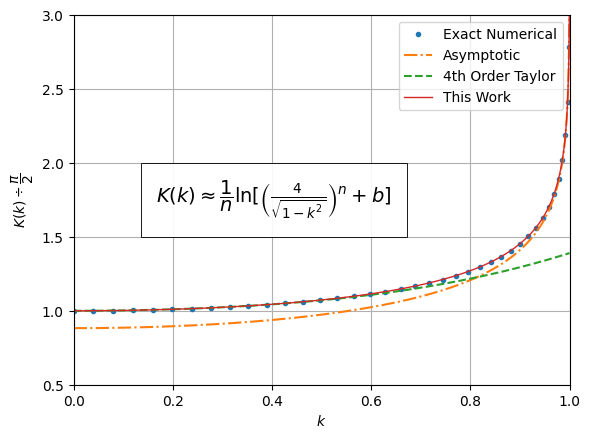

In [4]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

# allocate amplitude theta0 and x
theta0 = np.arange(0,np.pi,.004)
k = np.sin(theta0/2)
N = len(k)

# compute exact K(k)
# Notes: scipy defines the arguments of elliptic function 
# differently, so that the k**2 is used instead of just k.
K_exact = scipy.special.ellipk(k**2)

# allocate array for comparisons
K_asym = np.zeros(N)
K_t4 = np.zeros(N)
K_ThisWork = np.zeros(N)
K_lima2008 = np.zeros(N)
K_ganley1985 = np.zeros(N)

for i in range(N):
    
    # (Lima 2008)
    if k[i] > 0.0:
        a = np.sqrt(1-k[i]**2)
        K_lima2008[i] = np.pi/2*( a**2/(1-a)*np.log(1/a) +  2*k[i]**2/np.pi*np.log(4/a)   )
    else:
        K_lima2008[i] = np.pi/2
    
    K_asym[i] = np.log(4/np.sqrt(1-k[i]**2))
    K_t4[i] = np.pi/2*(1 + 1/4*k[i]**2 + ((1*3)/(2*4))**2*k[i]**4 )
    
    # (Ganley 1985)
    alpha = np.sqrt(3)/2*theta0[i]
    if alpha > 0.0: K_ganley1985[i] = np.pi/2*np.sqrt(alpha/np.sin(alpha))
    else: K_ganley1985[i] = 1.0

    n = (np.log(4) - np.log(np.pi))/(np.pi/2 - np.log(4))
    b = np.exp(n*np.pi/2) - 4**n
    K_ThisWork[i] = 1/n*np.log( (4/np.sqrt(1-k[i]**2))**n + b)

plt.plot(k, K_exact*2/np.pi,'.',markevery=20, label='Exact Numerical')
plt.plot(k, K_asym*2/np.pi,'-.', label='Asymptotic')
plt.plot(k, K_t4*2/np.pi,'--', label='4th Order Taylor')
plt.plot(k, K_ThisWork*2/np.pi, linewidth=1,label='This Work')

plt.text(30/180,1.73,'$K(k) \\approx  \\dfrac{1}{n} '
         '\\ln [   \\left(\\frac{4}{\sqrt{1-k^2}}\\right)^n + b ]$', fontsize=14, \
        bbox=dict(boxstyle='square,pad=0.8', facecolor='white', alpha=0.9, edgecolor='black', linewidth=0.7))

#plt.title('Complete Elliptical Integral of the First Kind')
plt.xlabel('$k$')
plt.ylabel('$K(k) \\div \\dfrac{\pi}{2}$')
plt.ylim([.5,3])
plt.xlim([0,1])
plt.legend()
plt.grid()
#plt.savefig('fig3.pdf')
plt.show()

### Figure 4: Comparisons to Existing Analytical Forms

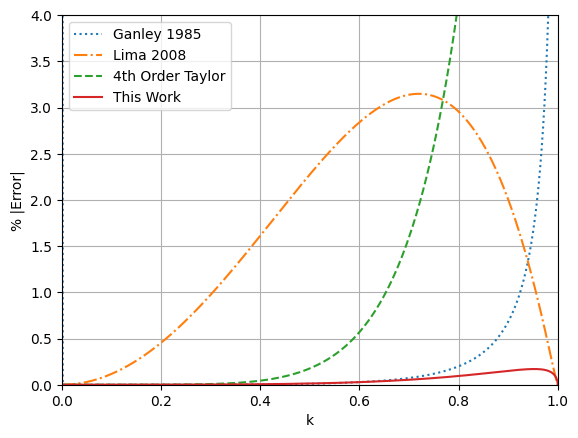

Maximum % |Error|
Lima 2008: 3.15
This Work: 0.17

Average % |Error|
Lima 2008: 1.56
This Work: 0.06


In [5]:
#
# Error comparison
#

plt.plot(k, np.abs(K_ganley1985-K_exact)*100./K_exact,':', label='Ganley 1985')
plt.plot(k, np.abs(K_lima2008-K_exact)*100./K_exact,'-.', label='Lima 2008')
plt.plot(k, np.abs(K_t4-K_exact)*100./K_exact,'--', label='4th Order Taylor')
plt.plot(k, np.abs(K_ThisWork-K_exact)*100./K_exact, label='This Work')

#plt.title('Error compared to the exact K(k)')
plt.xlabel('k')
plt.ylabel('% |Error|')
plt.xlim([0,1])
plt.ylim(0,4)
plt.legend()
plt.grid()
#plt.yscale('log')
plt.show()
#plt.savefig('fig4.pdf')

print('Maximum % |Error|')
print('Lima 2008: %.2f' % ( max(np.abs(K_lima2008-K_exact)*100./K_exact) ) )
print('This Work: %.2f' % ( max(np.abs(K_ThisWork-K_exact)*100./K_exact) ) )

print('\nAverage % |Error|')
print('Lima 2008: %.2f' % ( np.average(np.abs(K_lima2008-K_exact)*100./K_exact) ) )
print('This Work: %.2f' % ( np.average(np.abs(K_ThisWork-K_exact)*100./K_exact) ) )

## Derivation of the Constant $n$ and $b$ in Eq. (8)

Below is a python code that symbollically derivatives of the proposed form, evaluated at $k = 0$. The derivatives can then be compared to that of the exact $K(k)$. Demanding that they agree upto the 2nd order will ensure that the proposed form approaches the exact limit when the amplitudes is small.

In [6]:
## checking taylor expansion of the proposed form
##
import sympy as sym

kk = sym.symbols('k', real=True)
bb = sym.symbols('b', real=True)
nn = sym.symbols('n', real=True)

# the proposed form
K0 = 1/nn*sym.ln((4/sym.sqrt(1-kk**2))**nn + bb)

print('0th Derivative: ', K0.subs(kk,0))
K1 = K0.diff(kk)
print('1st Derivative: ', K1.subs(kk,0))
K2 = K1.diff(kk)
print('2nd Derivative: ', K2.subs(kk,0))
K3 = K2.diff(kk)
print('3rd Derivative: ', K3.subs(kk,0))

0th Derivative:  log(4**n + b)/n
1st Derivative:  0
2nd Derivative:  4**n/(4**n + b)
3rd Derivative:  0


Taylor series (sometimes called power series) of the exact $K(k)$ is

$$K(k) = \frac{\pi}{2}[1 + (\frac{1}{2})^2 k^2 + (\frac{1\cdot3}{2\cdot4})^2 k^4 + (\frac{1\cdot3\cdot5}{2\cdot4\cdot6})^2 k^6 + \cdots]\tag{S2}$$

Therefore, $K(0) = \frac{\pi}{2}$ and $K''(0) = \frac{\pi}{4}$. From the output of the python code above, it follows that

$$\begin{align} \frac{1}{n}\log(4^n+b) = \frac{\pi}{2} & \tag{S3} && \\ \frac{4^n}{4^n+b} = \frac{\pi}{4}  & \tag{S4} && \end{align}$$

which lead to

$$ n  = \frac{\ln 4 -  \ln \pi}{\pi/2 -  \ln 4} \quad \text{and} \quad  b  = e^{n\pi/2} - 4^n$$

## Derivation the CKS in Eq. (2)

The equation of motion for a physical pendulum reads

$$\frac{d^2 \theta}{dt^2} + \frac{LMg}{I}\sin \theta = 0\tag{S5}$$

$L$ is the distance from a pivot point to the center of mass. $I$ is the moment of inertia about the pivot point. For a simple pendulum, $I = ML^2$; so the equation of motion reduces to

$$\frac{d^2 \theta}{dt^2} + \frac{g}{L}\sin \theta = 0 \tag{S6}$$

The above form is still inconvenient to work with due to the factor $\frac{g}{L}$ that would have to tag along throughout the derivations. We define a scaled time, 

$$\tau \equiv \sqrt{\frac{g}{L}}t \label{eq_deftime}\tag{S7}$$

so that the equation of motion reduces further to


$$\frac{d^2 \theta}{d\tau^2} + \sin \theta = 0 \label{eq_motion}\tag{S8}$$

Once the solution $\theta(\tau)$ is found, it can be converted back to a function the physical time $\theta(\sqrt{\frac{g}{L}}t)$. If the pendulum is at rest initially with an amplitude $\theta_0$, the solution of Eq. (\ref{eq_motion}) is typically written in the litterature as


$$\theta(\tau) = 2 \arcsin \left[ k \, \text{sn}(\tau+K, k)\right] \label{DLMF_sn_sol}\tag{S9}$$

see [DLMF, 22.19.E2](https://dlmf.nist.gov/22.19.E2). Here, $k = \sin \frac{\theta_0}{2}$. $\text{sn}(z,k)$ is one of the Jacobi elliptic functions; and $K$ is the complete elliptical integral of the first kind, which in this context is a quarter of the period of the pendulum. However, the time dependent can be shifted from the quarter period $K$ back to zero by using the relation

$$\text{sn}(z+K,k) = \text{cd}(z,k)\label{DLMF_sn_cd}\tag{S10}$$

see [DLMF, 22.4.T3](https://dlmf.nist.gov/22.4#T3). $\text{cd}(z,k)$ is another Jacobi elliptic function. Therefore, the solution takes the form

$$\theta(\tau) = 2 \arcsin \left[ k \, \text{cd}(\tau, k)\right] \tag{S11}$$

To avoid the $\arcsin[\cdots]$ dependent above and steering toward a simpler Fourier form, the following integral property is used.

$$\int \text{sd}(x,k) \, dx = -\frac{1}{k k'}\arcsin[  k \, \text{cd}(x, k)] \label{DLMF_int_sd}\tag{S12}  $$

see [DLMF, 22.14.E5](https://dlmf.nist.gov/22.14.E5). Note that the minus sign is taken out of $\arcsin[\cdots]$ function, as compared to the reference. $\text{sd}(z,k)$ is one of the Jacobi elliptic function. Therefore, the solution can now be written as

$$\theta(\tau) = - 2 k k' \int \text{sd}(\tau,k) \, d\tau \label{eq_7}\tag{S13}$$

A fourier expansion of $\text{sd}(z, k)$ is also available. It reads

$$\text{sd}(z,k) = \frac{2\pi}{K k k'}\sum_{n=0}^{\infty} \frac{(-1)^n q^{n+\frac{1}{2}}\sin ((2n+1)\zeta)}{1+q^{2n+1}}  \label{DLMF_sd_fourier}\tag{S14}$$

see [DLMF, 22.11.E5](https://dlmf.nist.gov/22.11.E5). The auxillary variables defined in the reference are: $k' = \sqrt{1-k^2}, q = e^{-\pi K(k')/K(k)}, \zeta = \frac{\pi z}{2K(k)}$. Before going any further, it is convenient to adjust the form of the summation index $n$. Note that $(2n+1)$ is always an odd integer, so we define an odd integer $m = (2n+1)$. The above Fourier expansion becomes

$$\text{sd}(\tau,k) = \frac{2\pi}{K k k'}\sum_{m\,\text{odd}} \frac{(-1)^{\frac{m-1}{2}} q^{\frac{m}{2}}\sin (\frac{m\pi}{2K}\tau)}{1+q^m} = \frac{2\pi}{K k k'}\sum_{m\,\text{odd}} \frac{(-1)^{\frac{m-1}{2}} \sin (\frac{m\pi}{2K}\tau)}{2\cosh(\kappa m \pi/2)}  \tag{S15}$$

Here, we define $\kappa \equiv \frac{K(\sqrt{1-k^2})}{K(k)}$. Substutute $\text{sd}(\tau,k)$ above into the integral in Eq. (\ref{eq_7}). The solution becomes


$$\theta(\tau) = -  \frac{2 \pi}{K} \sum_{m\,\text{odd}} \frac{(-1)^{\frac{m-1}{2}} }{\cosh(\kappa m \pi/2)}  \int \sin (\frac{m\pi}{2K}\tau) \, d\tau \tag{S16}$$

Here, the integration is pushed through the summation to meet the time dependent $\sin(\frac{m\pi}{2K}\tau)$. The integration can easily be performed, yielding

$$\theta(\tau) =  \sum_{m\,\text{odd}}   \frac{(-1)^{\frac{m-1}{2}}}{m}  \frac{4}{\cosh(\kappa m \pi /2)}   \cos (\frac{m\pi}{2K}\tau)  \tag{S17}$$

However, $4K$ can be interpreted as the period in the scaled time $\tau$. Therefore, 

$$\cos(\frac{m\pi}{2K}\tau) = \cos(\frac{2 m\pi}{4 K}\tau)\tag{S18}$$

Notice the ratio of the scaled time $\tau$ to its period $4K$. Upon converting from the scaled time to the physical time $\tau \rightarrow \sqrt{\frac{g}{L}} t$, so is the period $4K \rightarrow \sqrt{\frac{g}{L}}T$. Hence, the factor $\sqrt{\frac{g}{L}}$ is eliminated inside the cosine fuctions. Renaming the index $m \rightarrow n$, the series becomes.

$$\theta(t) =  \sum_{n\,\text{odd}} a_n   \cos (\frac{2 n \pi}{T} t) \label{cosine_series}  \tag{S19}$$

where the Fourier coefficients (only for n odd) are

$$a_n =   \frac{(-1)^{\frac{n-1}{2}}}{n}  \frac{4}{\cosh(\kappa n \pi /2)},\quad \kappa \equiv \frac{K(\sqrt{1-k^2})}{K(k)} \tag{S20}$$

But the series in Eq.(\ref{cosine_series}) when the pendulum starts at rest at the initial angle $\theta_0$. Shifting the by a quarter of the period causes the pendulum to start at the bottom, with initial angular speed $\omega_m$ to jump start the motion.

$$\theta(t) =  \sum_{n\,\text{odd}} a_n   \cos (\frac{2 n \pi}{T} t - \frac{n\pi}{2})   \tag{S21}$$

Use a simple trigonometry identity $\cos(A-B) = \cos A \cos B + \sin A \sin B$ and the fact that $n$ is always an odd number, we have

$$\theta(t) =  \sum_{n\,\text{odd}} a_n (-1)^{\frac{n-1}{2}}   \sin (\frac{2 n \pi}{T} t )   \tag{S22}$$

The alternating $\pm1$ sign can be absorbed into $a_n$, leading to an even simpler form

$$\theta(t) =  \sum_{n\,\text{odd}} a_n    \sin (\frac{2 n \pi}{T} t  + n\delta)   \tag{S23}$$

$$a_n =     \frac{4}{n\, \cosh(\kappa n \pi /2)},\quad \kappa \equiv \frac{K(\sqrt{1-k^2})}{K(k)} \tag{S24}$$


## the Phase Constant

The phase constant $\delta$ for the swinging motion can be computed by finding a root of 

$$f(\delta) = 0 = \theta_0 - \sum_{n\,\text{odd}} a_n   \sin ( n\delta)\tag{S25} $$

For Newton root finding method, an initial guess of $\delta_0$ need to be given. The successive values of $\delta_n$ can be updated using

$$ \delta_{n+1} = \delta_n - \frac{f(\delta_n)}{f'(\delta_n)} \label{Newton_update}\tag{S26}$$

The iterations stop when the $\delta_n$ converges. The initial guess $\delta_0$ can be determined from using only the first term in the summation, namely.

$$ 0 = \theta_0 - a_1 \sin(\delta_0) \tag{S27}$$

Therefore,

$$\delta_0  =  \arcsin(\theta_0/a_1) \tag{S28}$$

In the python codes above, in the subroutine **phase_CKS(...)**, the iterations in Eq. (\ref{Newton_update}) continue until $\delta_{n+1}$ differs from $\delta_n$ smaller than $10^{-8}$. The converged value of $\delta$ is then used to evaluate $\theta(t)$ using CKS. 

## References

Ganley, W. P. (1985). Simple pendulum approximation. American Journal of Physics, 53(1), 73–76. https://doi.org/10.1119/1.13970

Lima, F. M. S. (2008). Simple ‘log formulae’ for pendulum motion valid for any amplitude. European Journal of Physics, 29(5), 1091–1098. https://doi.org/10.1088/0143-0807/29/5/021

[DLMF]  NIST Digital Library of Mathematical Functions. https://dlmf.nist.gov/, Release 1.2.4 of 2025-03-15. F. W. J. Olver, A. B. Olde Daalhuis, D. W. Lozier, B. I. Schneider, R. F. Boisvert, C. W. Clark, B. R. Miller, B. V. Saunders, H. S. Cohl, and M. A. McClain, eds.